In [1]:
%load_ext autoreload
%autoreload 2

# Load packages

In [2]:
import os
import cv2
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt

In [80]:
from ImgAligner.feature import normalize_uint16_to_uint8, orb_feature_matching, \
     akaze_feature_matching, \
     compute_homography_and_warp, scale_search, extract_and_warp_roi_correct, \
     check_local_consistency, piecewise_affine_warp, tps_warp

In [5]:
from ImgAligner.feature.feature_detector import scale_search

In [17]:
from ImgAligner.utils import plot_inlier_matches, adjust_homography_scale, plot_overlay, plot_match_consistency

# Process images

In [21]:
# put paths here:
img_path = '/lustre/groups/ml01/workspace/mostafa.shahhosseini/data/MMann/roi_whole_slide/'

In [22]:
# Load ch1, ch2, ch3 for Round 0
img1_ch1 = tf.imread(os.path.join(img_path, 'Round0_ch0.tif'))
img1_ch2 = tf.imread(os.path.join(img_path, 'Round0_ch1.tif'))
img1_ch3 = tf.imread(os.path.join(img_path, 'Round0_ch2.tif'))

# Load ch1, ch2, ch3 for Round 1
img2_ch1 = tf.imread(os.path.join(img_path, 'Round1_ch0.tif'))
img2_ch2 = tf.imread(os.path.join(img_path, 'Round1_ch1.tif'))
img2_ch3 = tf.imread(os.path.join(img_path, 'Round1_ch2.tif'))

In [63]:
sum1 = (img1_ch1+ img1_ch2+ img1_ch3)
img1_rgb = cv2.merge([
    normalize_uint16_to_uint8(sum1),
    normalize_uint16_to_uint8(sum1),
    normalize_uint16_to_uint8(sum1)
])
sum2 = (img2_ch1+ img2_ch2+ img2_ch3)
img2_rgb = cv2.merge([
    normalize_uint16_to_uint8(sum2),
    normalize_uint16_to_uint8(sum2),
    normalize_uint16_to_uint8(sum2)
])


img1_roi = img1_rgb[:, :]
img2_roi = img2_rgb[:, :]

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

##### A technique that improves the contrast of an image by spreading out the intensity values (so darks become darker, brights become brighter).

In [166]:
# --- CLAHE on each channel ---
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10, 10))
img1_enh = cv2.merge([clahe.apply(c) for c in cv2.split(img1_roi)])
img2_enh = cv2.merge([clahe.apply(c) for c in cv2.split(img2_roi)])

In [167]:
# --- Downsample ---
scale = 0.01
img1_down = cv2.resize(img1_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
img2_down = cv2.resize(img2_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

### Rigid Transformation


In [168]:
# Fint match_orb features
orb_features = orb_feature_matching(img1_down, img2_down)
good_matches, kp1, kp2, src_pts, dst_pts = orb_features
len(good_matches)

105

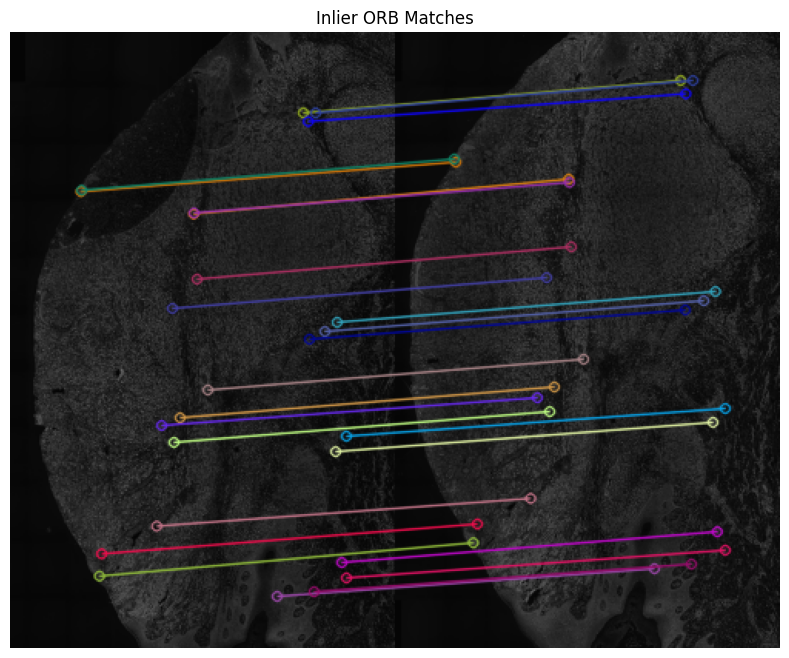

In [ ]:
# Compute H (transformation) and apply it
H, img2_aligned, inlier_matches = compute_homography_and_warp(img1_down, img2_down, src_pts, dst_pts, good_matches, ransac_thresh=3.0)

# plot the identified ORB features
plot_inlier_matches(img1_down, img2_down, kp1, kp2, inlier_matches, title="Inlier ORB Matches")


# we also adjust H to the full resolution image
H_fullres=adjust_homography_scale(H, scale)


# We now start working with the ROI

In [170]:
x0, y0 = 10000, 20000
tile_size=8000
tile_roi1, tile_roi2 = extract_and_warp_roi_correct(img1_enh, img2_enh, x0, y0, tile_size, H_fullres)

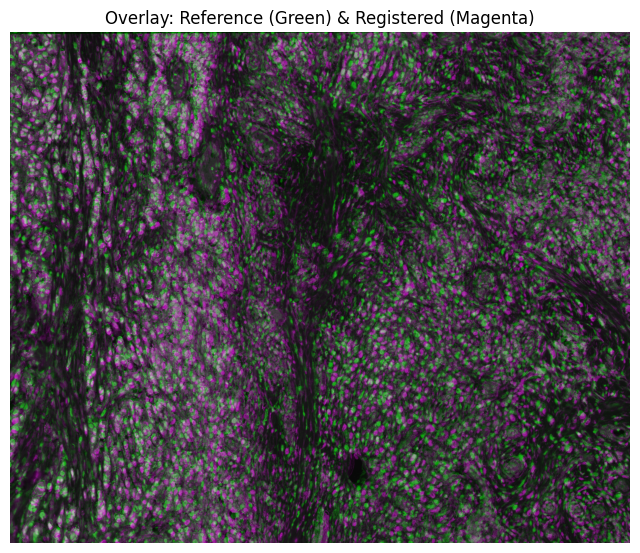

In [171]:
plot_overlay(tile_roi1, tile_roi2, figsize=(8, 8))

In [172]:
H, inliers, pts1, pts2, kp1, kp2 = akaze_feature_matching(tile_roi1, tile_roi2)

Total matches: 1120; Inliers after RANSAC: 61


In [178]:
n_neighbors = 4
error_threshold = 50.0  # pixels, adjust based on your data
consistency_flags = check_local_consistency(pts1, pts2, n_neighbors, error_threshold)
consistent_matches = [m for m, c in zip(inliers, consistency_flags) if c]
inconsistent_matches = [m for m, c in zip(inliers,consistency_flags) if not c]
len(consistent_matches), len(inconsistent_matches)

(20, 41)

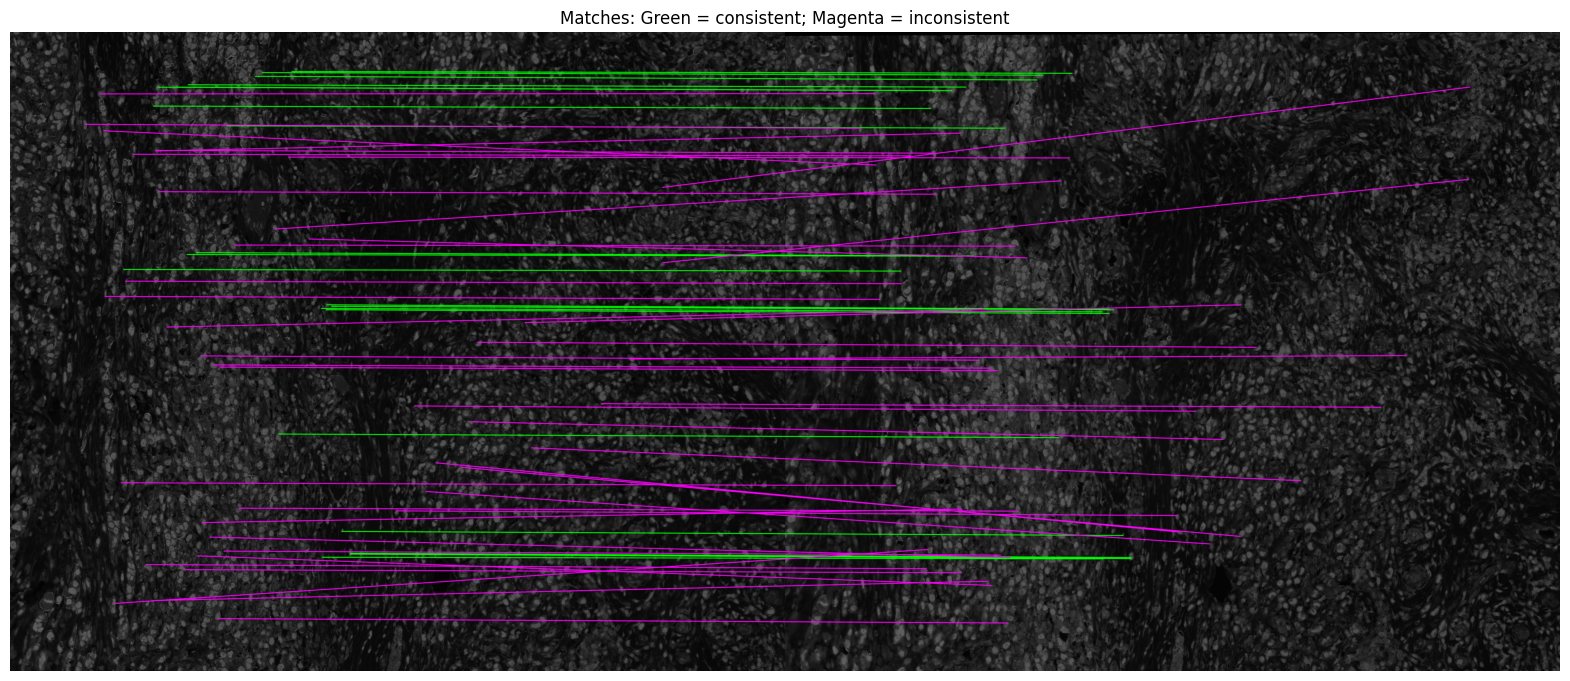

In [179]:
plot_match_consistency(tile_roi1, tile_roi2, kp1, kp2, consistent_matches, inconsistent_matches)

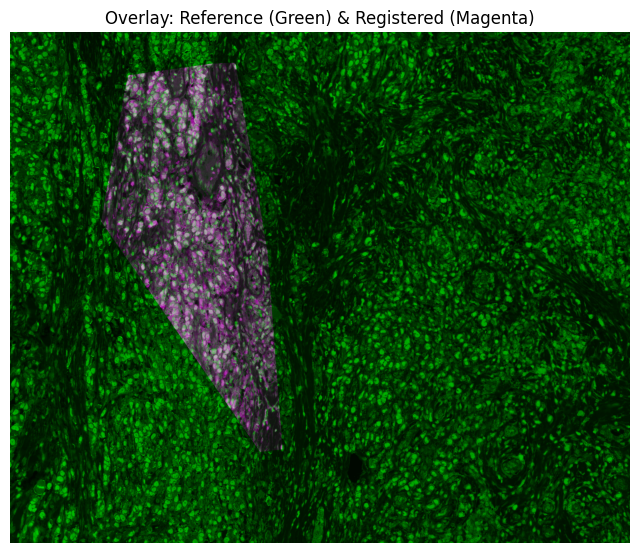

In [180]:
# 1. Extract matched points from keypoints and good matches
pts_mov = np.float32([kp1[m.queryIdx].pt for m in consistent_matches])  # from roi1_gray (reference)
pts_ref = np.float32([kp2[m.trainIdx].pt for m in consistent_matches])  # from roi2_gray (moving)
roi2_tsp_warped = piecewise_affine_warp(pts_mov, pts_ref, tile_roi2)
# overlay
plot_overlay(tile_roi1, roi2_tsp_warped, figsize=(8, 8))

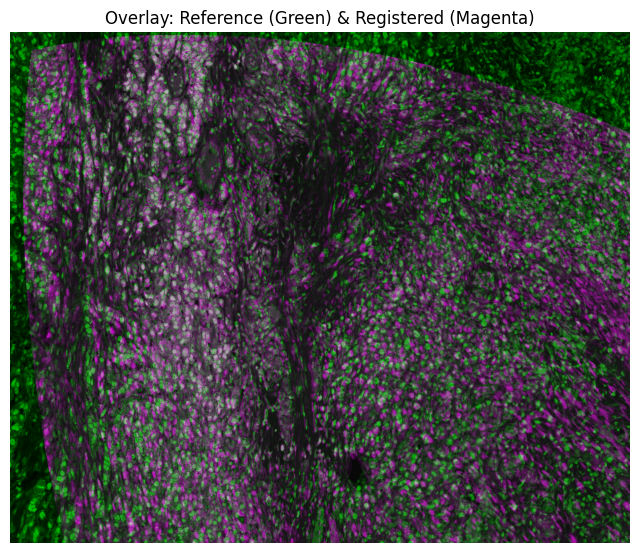

In [181]:
# Assume consistent_matches, kp1, kp2, tile_roi1, tile_roi2 are already defined
pts_mov = np.float32([kp1[m.queryIdx].pt for m in consistent_matches])  # moving
pts_ref = np.float32([kp2[m.trainIdx].pt for m in consistent_matches])  # reference

roi2_tps_warped = tps_warp(pts_mov, pts_ref, tile_roi2)
# Overlay and visualize
plot_overlay(tile_roi1, roi2_tps_warped, figsize=(8, 8))
